### Librerie

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

<ipython-input-44-d83832895324>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


### Indici

In [ ]:
# REPO DI NANDAY <3
import json
import requests
import urllib.parse
response = requests.get("https://api.github.com/repos/NandayDev/MSCI-Historical-Data/git/trees/main?recursive=1")
json_response = json.loads(response.text)
dfs=[]
for branch in json_response["tree"]:
  if ("countries" in branch["path"] or "indexes" in branch["path"] ) and "csv" in branch["path"]:
      filename = "https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/" + urllib.parse.quote(branch["path"])
      print(filename)
      dfs.append(pd.read_csv(filename,index_col=0,skiprows=1,header=0,names=["Date",filename[filename.rfind("/")+1:-4].replace("%20"," ")]))
for branch in json_response["tree"]:
  if ("curvo" in branch["path"] ) and "csv" in branch["path"]: # in modo da averli DOPO e quindi in caso di duplicati scartare QUESTI e non i precedenti
      filename = "https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/" + urllib.parse.quote(branch["path"])
      print(filename)
      dfs.append(pd.read_csv(filename,index_col=0,skiprows=1,header=0,names=["Date",filename[filename.rfind("/")+1:-4].replace("%20"," ")]))

https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20ARGENTINA.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20AUSTRALIA.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20AUSTRIA.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20BAHRAIN%20DOMESTIC.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20BAHRAIN.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20BANGLADESH.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20BELGIUM.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20BOSNIA%20AND%20HERZEGOVINA.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/countries/MSCI%20BOTSWANA.csv
https://raw.githubusercontent.com/NandayDev/MSCI-Historical-Data/main/c

In [ ]:
dati=pd.concat(dfs,axis=1).sort_values(by="Date")
dati=dati.iloc[:,~dati.columns.duplicated()] # elimino i duplicati
# ATTENZIONE SISTEMIAMO RUSSIA VALUE e RUSSIA GROWTH
dati.loc["2022-03":,"MSCI RUSSIA VALUE"].fillna(0.001, inplace=True)
dati.loc["2022-03":,"MSCI RUSSIA GROWTH"].fillna(0.001, inplace=True)
dati.fillna(method="ffill",limit=6,inplace=True)

# @

## Funzioni

In [ ]:
def rend(p):
  r = (p/p.shift(1)-1).dropna()
  return r

In [ ]:
def barchart(r,titolo,positivo,negativo):
  plt.figure(figsize=(14,6))
  bars = plt.bar(r.index,r.iloc[:,0])
  rettangolo_blu = mpatches.Patch(color='blue')
  rettangolo_arancione = mpatches.Patch(color='green')
  for bar in bars:
      if bar.get_height() > 0:
          bar.set_color('blue')
          bar.set_label(positivo)
      else:
          bar.set_color('green')
          bar.set_label(negativo)

  plt.xlabel('Anno inizio portafoglio')
  plt.ylabel('Delta rendimento [%]')
  plt.title(titolo)
  plt.legend(handles=[rettangolo_blu,rettangolo_arancione], labels=[positivo,negativo], loc='upper left', bbox_to_anchor=(0.2, -0.1), ncol=2)
  plt.show()

In [ ]:
def rolling(r,durata):
  rolling = r.rolling(window=12).sum()
  #rolling.index = rolling.index-pd.DateOffset(years=1)
  rolling = rolling.dropna()
  rolling = rolling.rolling(window=durata*12).mean()
  rolling.index = rolling.index-pd.DateOffset(years=durata)
  return rolling.dropna()

In [ ]:
def rolling2(r,durata):
  mesi = r.index
  maxyear= r.index.year.max()
  indice = [mese for mese in mesi if mese.year<=maxyear-durata]
  rr = []
  stdev = []
  for i in indice:
    r = r[(r.index>=i) & (r.index<i+pd.DateOffset(years=durata))]
    sd = np.std(r)*np.sqrt(12)
    rr.append(r.mean()*12)
    stdev.append(sd)

  rr = pd.DataFrame(rr, index=indice)
  stdev = pd.DataFrame(stdev, index=indice)

  return rr, stdev

## €

In [ ]:
c = ['MSCI USA','MSCI WORLD ex USA']
msci = dati[c]
rendimenti = rend(msci)
rendimenti.index = pd.to_datetime(rendimenti.index + '-01')

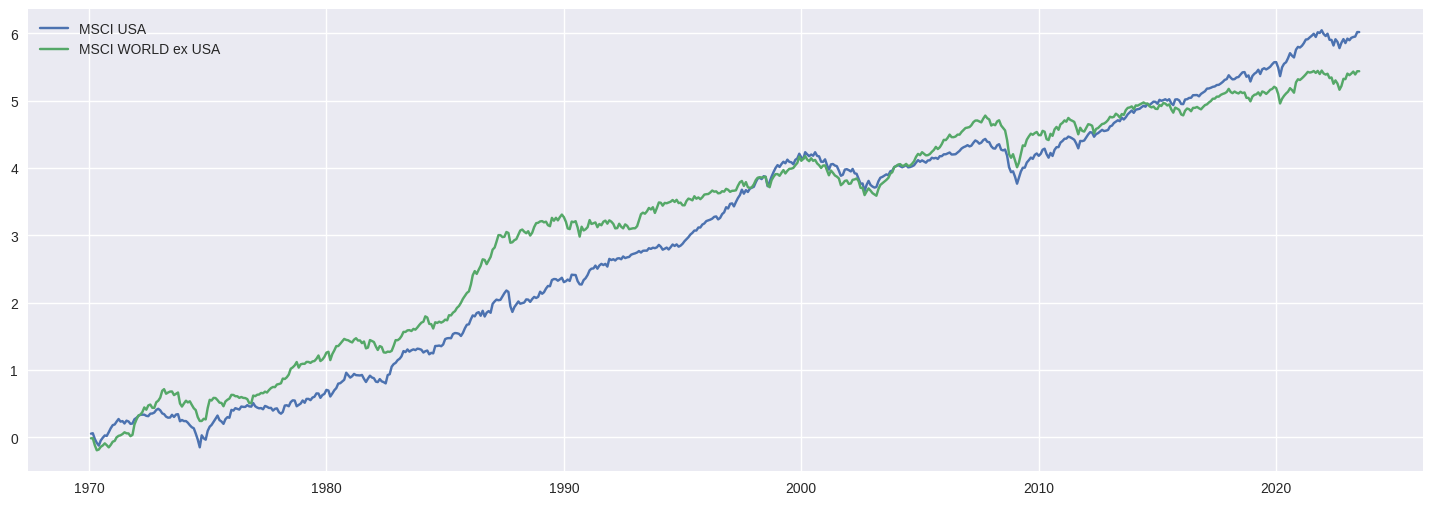

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(rendimenti.cumsum(),label=rendimenti.columns)
plt.legend()
plt.show()

In [ ]:
yrend = rendimenti.resample('A').sum()
yrend.index = yrend.index.year

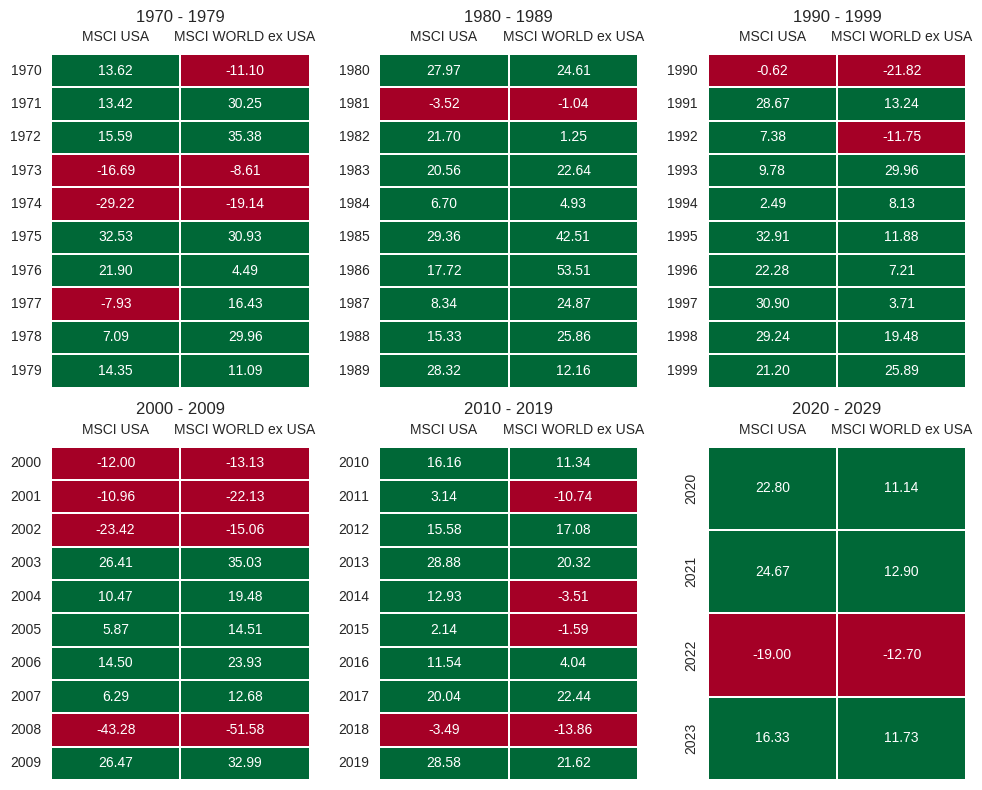

In [ ]:
# Dividere il DataFrame in sottoinsiemi per ogni 10 anni
sottoinsiemi = [yrend[(yrend.index>=i) & (yrend.index<i+10)] for i in range(yrend.index.min(), yrend.index.max(), 10)]

# Creare il grafico heatmap con subplot
num_colonne = 3
num_righe = 2
fig, axs = plt.subplots(num_righe, num_colonne, figsize=(10, 8))

for i, subset in enumerate(sottoinsiemi):
    riga = i // num_colonne
    colonna = i % num_colonne
    ax = sns.heatmap(subset*100, ax=axs[riga,colonna], cmap='RdYlGn', linecolor='white', linewidth=0.1, annot=True, fmt=".2f", cbar=False, vmin=-0.5, vmax=0.5)
    ax.set_title(f'{1970 + i * 10} - {1979 + i * 10}')
    ax.xaxis.set_ticks_position('top')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
yrend.describe()

,MSCI USA,MSCI WORLD ex USA
count,54.000000,54.000000
mean,0.111483,0.100713
std,0.167317,0.192805
min,-0.432816,-0.515827
25%,0.038201,-0.014546
50%,0.144215,0.120207
75%,0.226699,0.236051
max,0.329112,0.535109


In [ ]:
deltarend = pd.DataFrame(yrend.iloc[:,0]-yrend.iloc[:,1],columns=['Delta'])

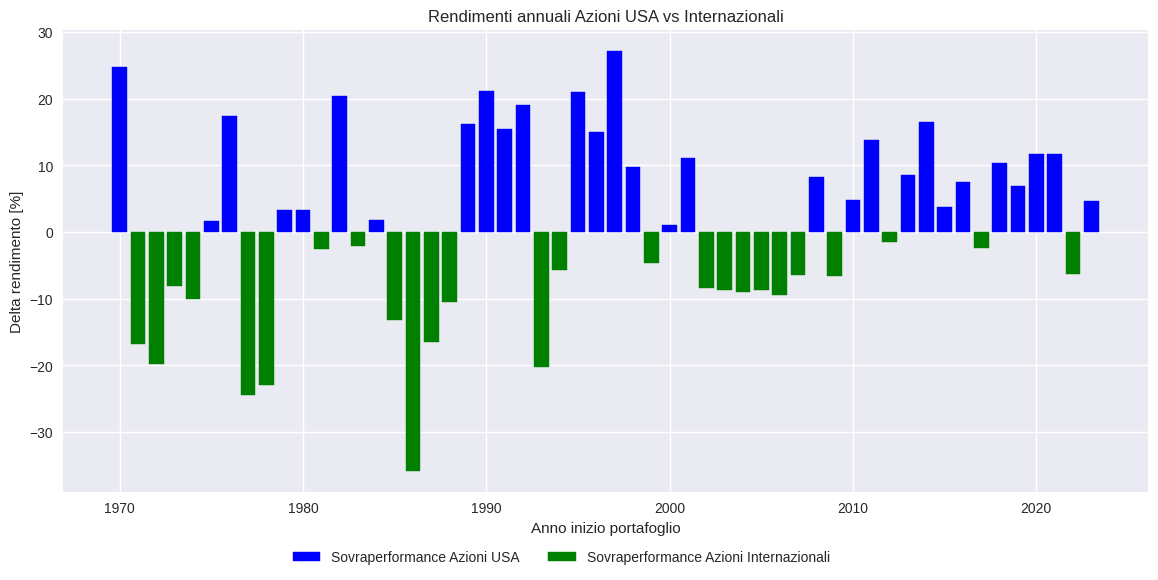

In [ ]:
barchart(deltarend*100,'Rendimenti annuali Azioni USA vs Internazionali','Sovraperformance Azioni USA','Sovraperformance Azioni Internazionali')

### Rolling

#### 10y

In [ ]:
# rolling 10 anni
roll10y = rolling(rendimenti,10)
delta10y = pd.DataFrame(roll10y.iloc[:,0]-roll10y.iloc[:,1])
delta10y_rolling = delta10y.resample('A').mean()
delta10y_rolling.index = delta10y_rolling.index.year

In [ ]:
roll10y.describe()

,MSCI USA,MSCI WORLD ex USA
count,512.000000,512.000000
mean,0.116798,0.104960
std,0.046493,0.053096
min,-0.007275,0.032390
25%,0.084733,0.065760
50%,0.129649,0.085418
75%,0.152869,0.146795
max,0.184343,0.225132


In [ ]:
roll10y.corr()

,MSCI USA,MSCI WORLD ex USA
MSCI USA,1.000000,0.501891
MSCI WORLD ex USA,0.501891,1.000000


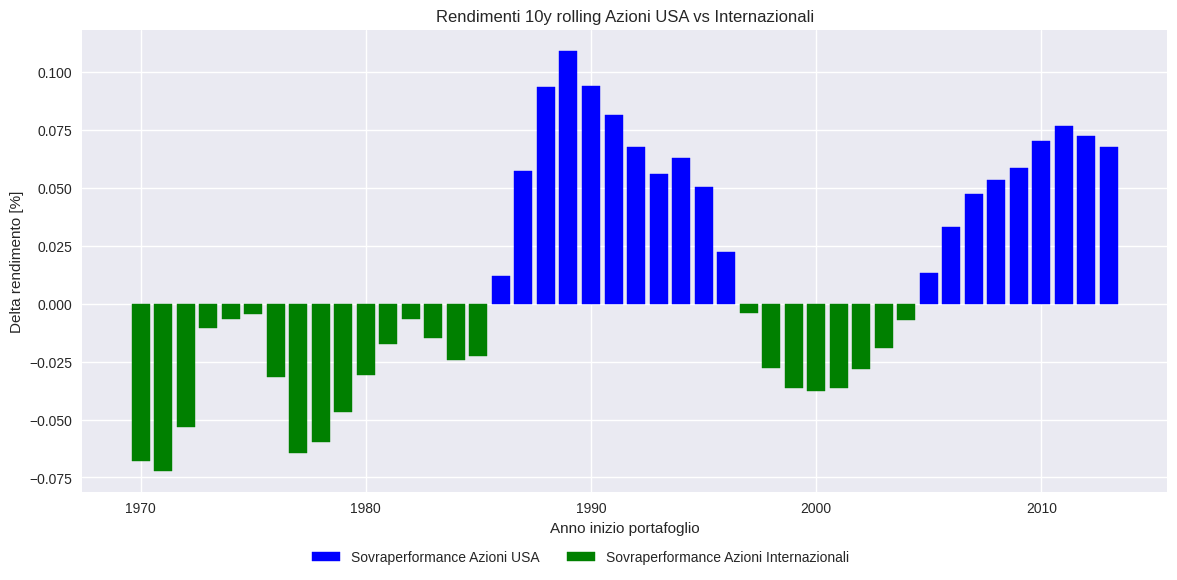

In [ ]:
barchart(delta10y_rolling,'Rendimenti 10y rolling Azioni USA vs Internazionali','Sovraperformance Azioni USA','Sovraperformance Azioni Internazionali')

#### 20y

In [ ]:
# rolling 20 anni
roll20y = rolling(rendimenti,20)
delta20y = pd.DataFrame(roll20y.iloc[:,0]-roll20y.iloc[:,1])
delta20y_rolling = delta20y.resample('A').mean()
delta20y_rolling.index = delta20y_rolling.index.year

In [ ]:
roll20y.describe()

,MSCI USA,MSCI WORLD ex USA
count,392.000000,392.000000
mean,0.116970,0.102526
std,0.028991,0.035943
min,0.067486,0.050231
25%,0.093705,0.070780
50%,0.116384,0.094291
75%,0.138076,0.139896
max,0.175266,0.162265


In [ ]:
roll20y.corr()

,MSCI USA,MSCI WORLD ex USA
MSCI USA,1.000000,0.836439
MSCI WORLD ex USA,0.836439,1.000000


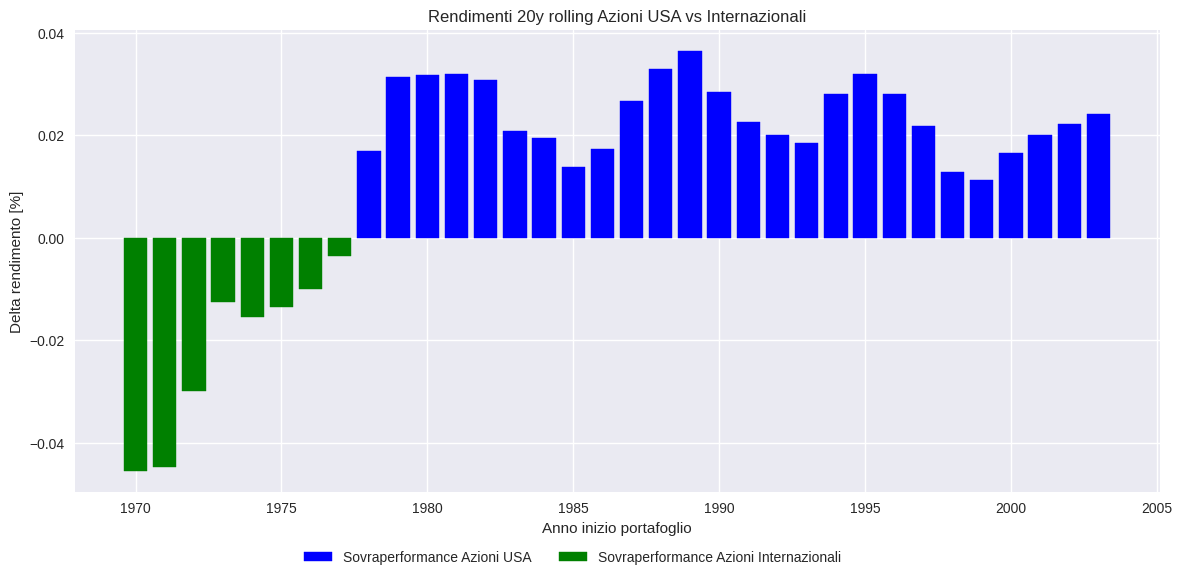

In [ ]:
barchart(delta20y_rolling,'Rendimenti 20y rolling Azioni USA vs Internazionali','Sovraperformance Azioni USA','Sovraperformance Azioni Internazionali')

In [ ]:
print(f'Correlazione totale: {round(rendimenti.corr().iloc[1,0],2)}')
print(f'Correlazione 10 anni rolling: {round(roll10y.corr().iloc[1,0],2)}')
print(f'Correlazione 20 anni rolling: {round(roll20y.corr().iloc[1,0],2)}')

Correlazione totale: 0.68
Correlazione 10 anni rolling: 0.5
Correlazione 20 anni rolling: 0.84


### Miglior PF

In [ ]:
# rolling 20 anni
pf = rendimenti
for i in range(10,100,10):
  pf[str(100-i)+'_'+str(i)] = pf.iloc[:,0]*(100-i)/100 + pf.iloc[:,1]*i/100

pf_rolling = rolling(pf,10)
pf_rr = pf_rolling.describe().iloc[1,:]/pf_rolling.describe().iloc[2,:]

In [ ]:
pf_rr

MSCI USA             2.512144
MSCI WORLD ex USA    1.976799
90_10                2.583837
80_20                2.630283
70_30                2.644899
60_40                2.623938
50_50                2.567711
40_60                2.480629
30_70                2.369994
20_80                2.244183
10_90                2.111017
dtype: float64

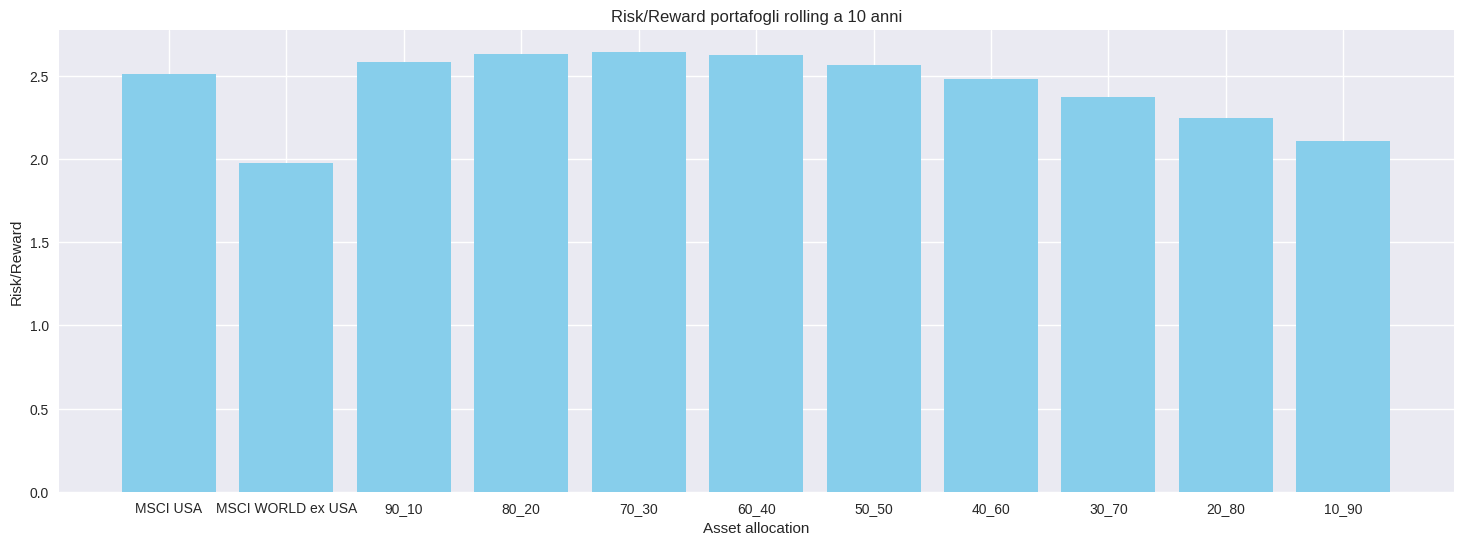

In [ ]:
# Disegna il grafico a colonne
plt.figure(figsize=(18,6))
plt.bar(list(pf_rolling.columns),pf_rr, color='skyblue')

# Aggiungi etichette al grafico
plt.xlabel('Asset allocation')
plt.ylabel('Risk/Reward')
plt.title('Risk/Reward portafogli rolling a 10 anni')

# Mostra il grafico
plt.show()